# How to Scale your Model

Link: https://jax-ml.github.io/scaling-book/

### Types of time

There are two types of time

- **computation time** - how much time accelerator spends on compute

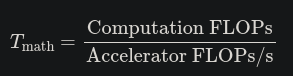

Computation FLOPs - how many FLOPs is needed to perform computation

Accelerator FLOPs/s - how many FLOPs accelerator can perform in one second

- **communication time** - how much time accelerator spends on sending/receiving data

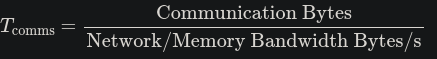

Communication Bytes - how many bytes is needed to read/write/send to another block inside accelerator or send to another accelerator

Network/Memory Bandwidth - it is what it is

### Upper and Lower bounds

Typically (but not always), computation within a single chip can be overlapped with communication within a chip and between chips. This means we can lower-bound training and inference time by using the maximum of computation and communication time. The upper bound is sum of these two times:

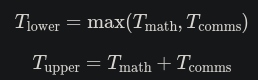

Usually we use optimize against the maximum as the algebra is simpler and we can usually come close to this bound by overlapping our communication and computation.

### Compute and communication bound

T<sub>math</sub> > T<sub>comms</sub> - full utilization from our hardware, we that this operation is **“compute-bound”** and this is desired situation

T<sub>math</sub> < T<sub>comms</sub> - underutilization because some fraction of our accelerator FLOPs/s is wasted waiting for data to be passed around, operation is **“communication-bound"**

### Arithmetic Intensity

 One way to tell if an operation will be compute or communication-bound is to look at its “arithmetic intensity” or “operational intensity”.

 **Definition**: the arithmetic intensity of an algorithm is given by the ratio of the total FLOPs it performs to the number of bytes it needs to communicate — either within a chip or between chips.

 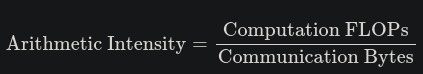

Accelerator has its own arithmetic intensity too and we can derive the relation between this intensities from relation between times:

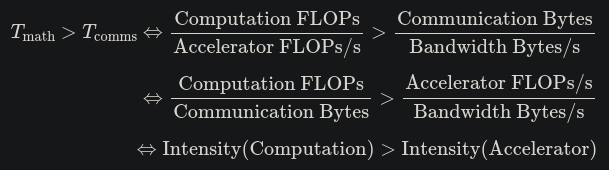

So, if we want our accelerator to be fully utilized by computing algorithm, we need intensity of this algorithm to be more than intensity of accelerator.


### Visualizing rooflines

We can visualize the tradeoff between memory and compute using a roofline plot, which plots the peak achievable FLOPs/s (throughput) of an algorithm on our hardware (the y-axis) against the arithmetic intensity of that algorithm (the x-axis). Here’s an example log-log plot:

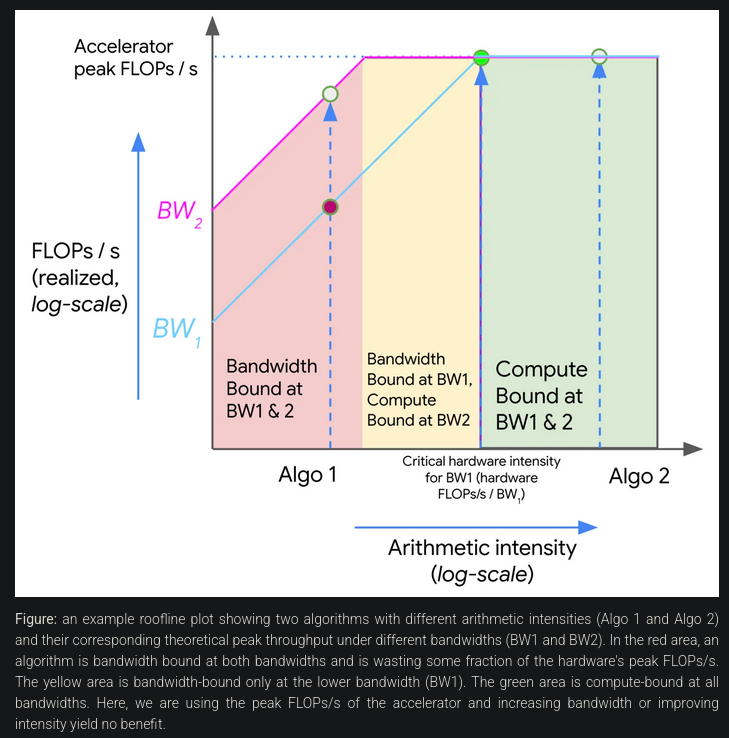

### Examples

1. Matrix multiplication, one TPU

X∗Y→Z where X has shape bf16[B,D]bf16[B,D] , Y has shape bf16[D,F]bf16[D,F] , and Z has shape bf16[B,F]bf16[B,F]

To do the matmul we need to load 2DF+2BD bytes, perform 2BDF FLOPs, and write 2BF bytes back.

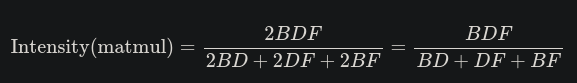

Assume that B (batch size) << D and F, then, assuming that our TPU has 1.97e14 compute power and 8.2e11 bandwidth:

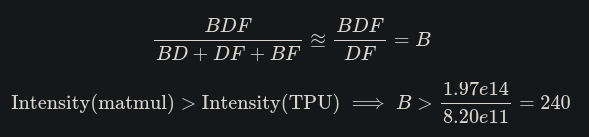

This is a reasonable assumption for Transformer matmuls since we typically have a local (per-replica) batch size B < 1024 tokens (not sequences) but D and F > 8000. Thus we generally become compute-bound when our per-replica batch size is greater than 240 tokens.

2. Matrix multiplication, two TPUs

Then we split half matrices X and Y by axis D:

A = X[:, :D // 2] @ Y[:D // 2, :] on TPU 0 and B = X[:, D // 2:] @ Y[D // 2:, :] on TPU 1

Then Z = A + B, but we won't consider final addition in our calculation.

T<sub>math</sub>​ is clearly half of what it was before, since each TPU is doing half the work, i.e.:

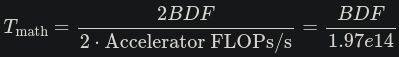

Now what about Tc<sub>comms</sub>? This now refers to the communication time between chips. This is just the total bytes sent divided by the network bandwidth, i.e.:

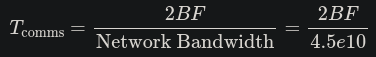

Then matmul intensity = BDF / 2 BF = D / 2 => to become compute bound we need D / 2 > 1.97e14/4.5e10 = 4377 => D > 8755.

Note that, unlike before, the critical threshhold now depends on D and not B.

## Sharding

### Sharding notation

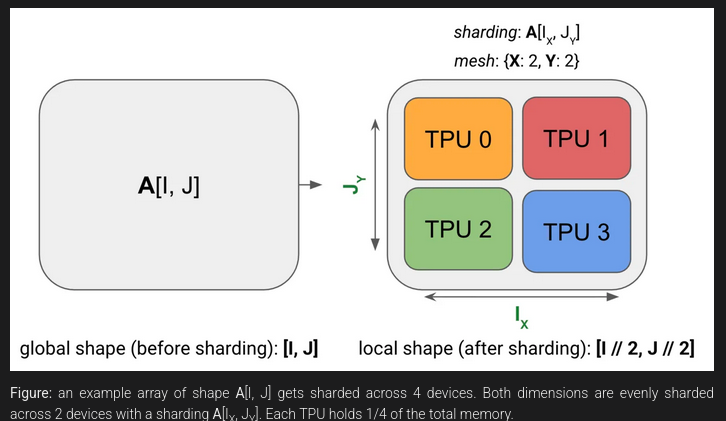

 - Mesh - shape of array of devices, example: grid 2 x 2 -> Mesh(devices=((0, 1), (2, 3)), axis_names=(‘X', ‘Y'))
 - Sharding: data array A[ I<sub>X</sub>, J<sub>Y</sub> ], which tells us to shard the first axis, I, along the mesh axis X, and the second axis, J, along the mesh axis Y. This sharding tells us that each shard holds 1/(∣X∣⋅∣Y∣) of the array. Sharding axis and mesh axis are independent, e.g. axis I can be sharded along both X and Y axis and sharding notation will be this: A[I<sub>XY</sub>​,J].
 
 Here's all possible shardings for 2D mesh of 4x4 devices and 2D data array:
 
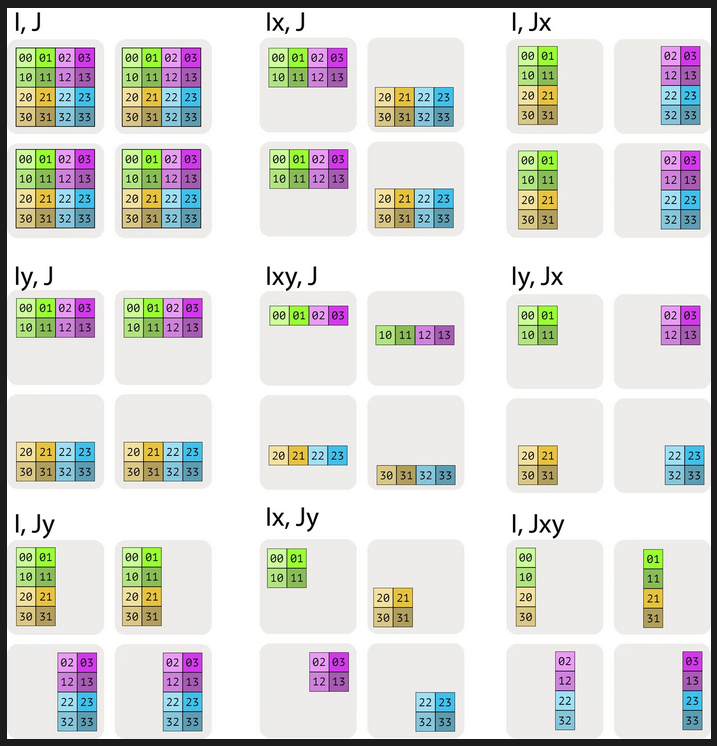
 
 I<sub>XY</sub> and I<sub>YX</sub> are different shardings
 
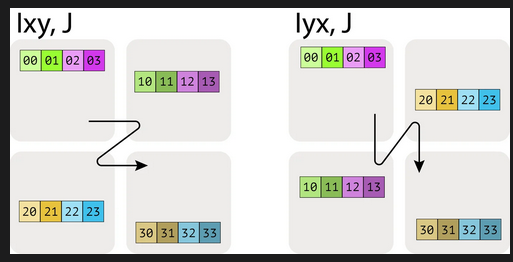
  
  ### Types of communication primitives that are used in sharding
  
  1. **AllGather** - removes the sharding along an axis and reassembles the shards spread across devices onto each device along that axis. Using the notation above, an AllGather removes a subscript from a set of axes, e.g.:
  
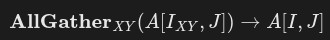
  
  **AllGather visualization**

In [5]:
from IPython.display import HTML

# Embed GIF using HTML
HTML('<img src="https://jax-ml.github.io/scaling-book/assets/img/all-gather.gif" width="450" height="250"/>')

  AllGather computation time. Let V be the number of bytes in the array, and X be the number of shards on the contracting dimension. Then from the above diagram, each hop sends V/∣X∣ bytes in each direction, so each hop takes
  
  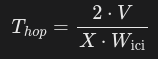
  
  where W<sub>ici</sub> is the bidirectional ICI (Inter Chip Connection) bandwidth. We need to send a total of ∣X∣/2∣ hops to reach every TPU, so the total reduction takes
  
  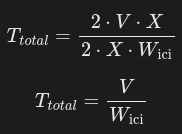
  
  Note that AllGather time doesn’t depend on X!
  
  Here is an empirical measurement of AllGather bandwidth on a TPU v5e 8x16 slice. The array is sharded across the second (16) axis so it has a full bidirectional ring.
  
  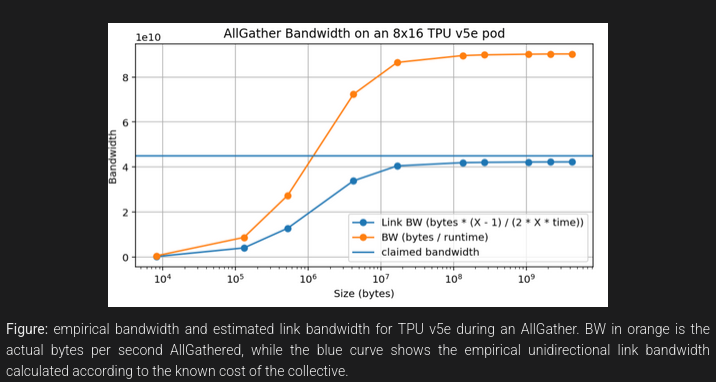
  
  What happens when we AllGather over multiple axes? When we gather over multiple axes, we have multiple dimensions of ICI over which to perform the gather. For instance, 
  AllGather<sub>XY</sub>([B, D<sub>XY</sub>]) operates over two hardware mesh axes. This increases the available bandwidth by a factor of N<sub>axes</sub>.

  When considering latency, we end up with the general rule:
  
  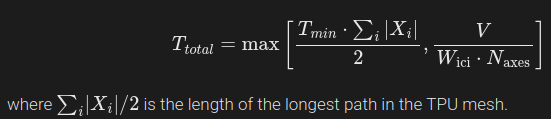
  
  2. **ReduceScatter** - removes a subscript ( F<sub>Y</sub>→F above), a ReduceScatter sums an unreduced/partially summed array and then scatters (shards) a different logical axis along the same mesh axis. [F]{U<sub>Y</sub>}→[F<sub>Y</sub>​]. The animation shows how this is done: note that it’s very similar to an AllGather but instead of retaining each shard, we sum them together. Thus, its latency is roughly the same, excluding the time taken to perform the reduction.
  
  **ReduceScatter visualization**

In [6]:
from IPython.display import HTML

# Embed GIF using HTML
HTML('<img src="https://jax-ml.github.io/scaling-book/assets/img/reduce-scatter.gif" width="450" height="250"/>')

  ReduceScatter is an opposite operation to AllGather. Likewise,  in the forward pass implies 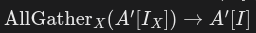 in the backwards pass.
  
  ReduceScatter computation time. The communication time for each hop is simply the per-shard bytes V/Y divided by the bandwidth W<sub>ici</sub>, as it was for an AllGather, so we have:
  
  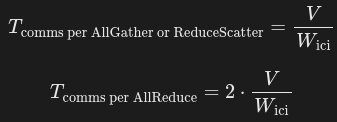
  
  3. **AllReduce** - removes partial sums, resulting in each device along the axis having the same fully-summed value. AllReduce takes an array with an unreduced (partially summed) axis and performs the sum by passing those shards around the unreduced axis and accumulating the result. The signature is:
  
  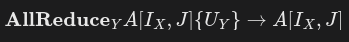

  AllReduce computation time. One mental model for how an AllReduce is performed is that every device sends its shard to its neighbors, and sums up all the shards that it receives. Clearly, this is more expensive than an AllGather because each “shard” has the same shape as the full array. Generally, an AllReduce is twice as expensive as an AllGather. One way to see this is to note that an AllReduce can be expressed as a composition of two other primitives: a ReduceScatter and an AllGather.
  
  4. **AllToAll** - the special case of a sharded transposition or resharding operation. e.g.
  
  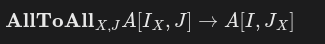
  
  AllToAlls are typically required to rearrange sharded layouts between different regions of a sharded computation that don’t have compatible layout schemes. They arise naturally when considering sharded mixture-of-experts models. You can think of an AllToAll as moving a subscript from one axis to another.
  
  **AllToAll visualization**

In [10]:
from IPython.display import HTML

# Embed GIF using HTML
HTML('<img src="https://jax-ml.github.io/scaling-book/assets/img/all-to-all.gif" width="750" height="250"/>')

  AllToAll computation time. Because an all to all doesn’t need to replicate all of the data of each shard across the ring, it’s actually cheaper than an AllGather (by a factor of ¼).
  
  Explanation:
  
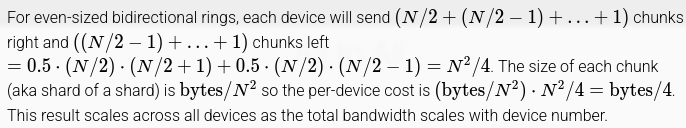
  
  ### Computation With Sharded Arrays
  
 The most common operation in machine learning is matrix multiplication
 
 There are 4 cases of sharded matrices multiplication
 
 1. **Case 1**: neither input is sharded along the contracting dimension. We can multiply local shards without any communication.
 
  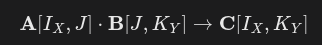
 
 2. Case 2: one input has a sharded contracting dimension. We typically “AllGather” the sharded input along the contracting dimension, because we can't multiply matrices when we have two different contracting dimensions.
 
  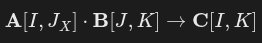
 
 3. Case 3: both inputs are sharded along the contracting dimension. We can multiply the local shards, then “AllReduce” the result.
 
  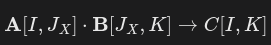
 
 4. Case 4: both inputs have a non-contracting dimension sharded along the same axis. We cannot proceed without AllGathering one of the two inputs first.
 
  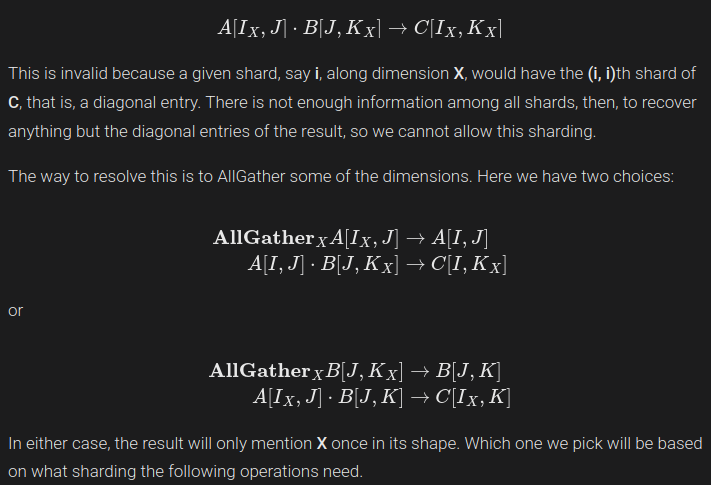

# Transformers

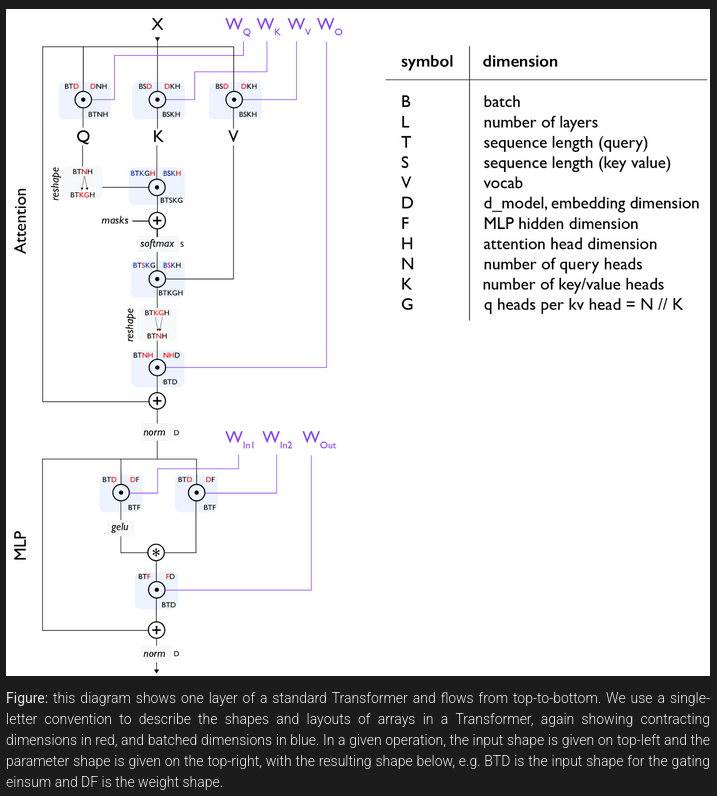

## Matmul forward and backward FLOPs calculation

Let’s start with vectors x,y and matrices A,B of the following shapes:

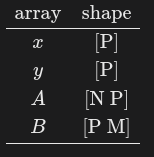

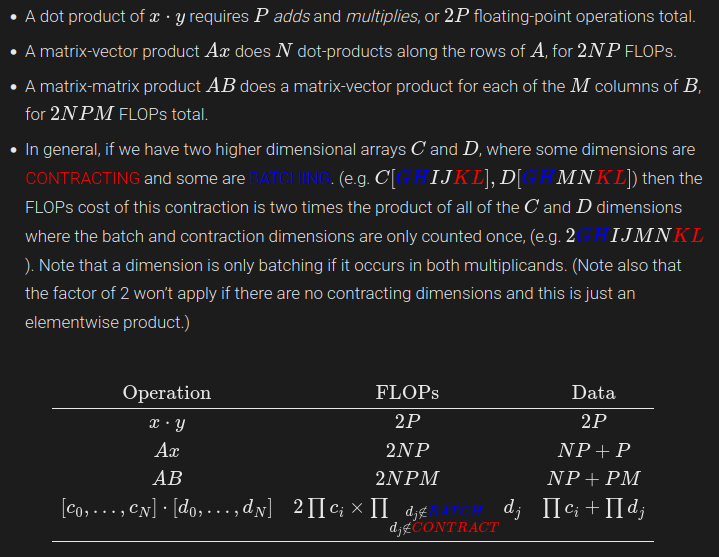

In [4]:
from IPython.display import HTML

# Embed GIF using HTML
HTML('<img src="https://jax-ml.github.io/scaling-book/assets/img/matmul-flops.gif" width="600" height="300"/>')

During forward path we have 2NPM flops. During backward path we have to calculate gradient for both matrices A and B:

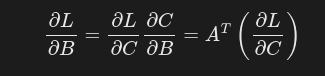

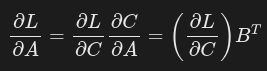

Where L - loss and C = A @ B.

Both of these operations take 2NPM FLOPs too since dL/dB and dL/dC have shapes [N, M] and contracting dimensions are N and M respectively.

Adding these up, we see that **during training, we have a total of 6NPM FLOPs**, compared to 2NPM during inference: 2NPM in the forward pass, 4NPM in the backward pass. 

Since PM is the number of parameters in the matrix, this is the simplest form of the famous 6 \* num parameters \* num tokens. Each token resquires 6 \* num parameters FLOPs.

## Transformer FLOPs and Params Calculation

### MLP

The MLPs of a Transformer typically consist of 2 input matmuls that are element-wise combined and a single output matmul:

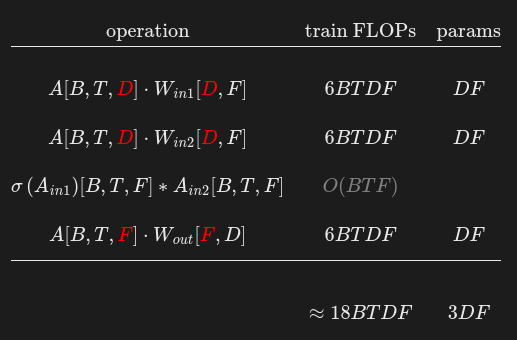

### Attention

Estimated cost of the QKVO matmuls:

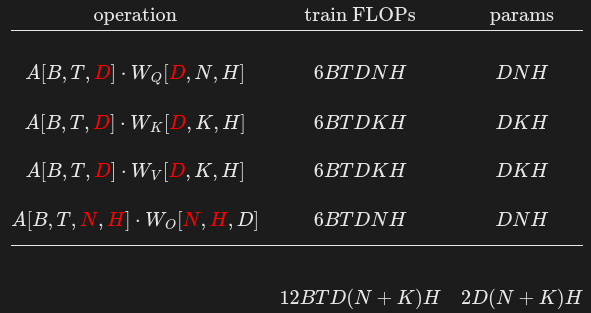

Estimated cost of the dot-product attention:

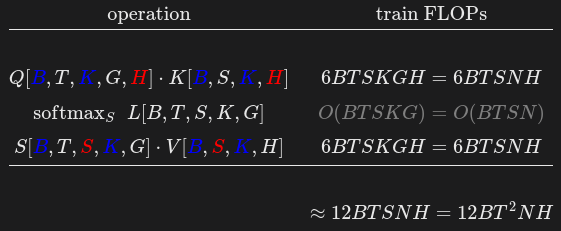

### Other operations (layer norm and vocab)

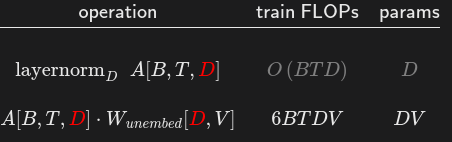

Total vocab train FLOPs are 12BTDV

### General rule of thumb for Transformer FLOPs

If we neglect the cost of dot-product attention for shorter-context training, then the total FLOPs across all layers is:

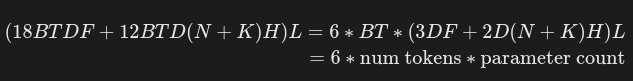

### Fractional cost of attention with context length

If we do account for dot-product attention above and assume F = 4D, D = NH and N = K:

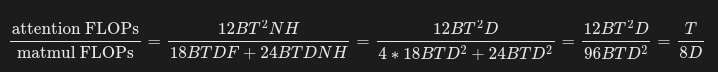

So the takeaway is that dot-product attention FLOPs only become dominant during training once T>8D. 

For D ~ 8k, this would be ~64K tokens. This makes some sense, since it means as the MLP size increases, the attention FLOPs become less critical. 

For large models, the quadratic cost of attention is not actually a huge obstacle to longer context training. 

However, for smaller models, even e.g. Gemma-27B, D=4608 which means attention becomes dominant around 32k sequence lengths. 

Flash Attention also helps alleviate the cost of long-context.

## Key-Value (KV) caching

Each KV cache is then effectively an array of size [2,S,L,K,H]. This is quite large! 

The total size of the Key-Value cache in int8 is 2SLKH. 

For a moderately-sized model with 8k context length, 64 layers, and KH=NH=D=8192, this is 2⋅8192⋅64⋅8192=8GiB. 

You can see why we would want to use Groupped Query Attention with K≪N.